In [1]:
import os
import json
from datetime import datetime
from json import JSONDecodeError
import pandas as pd
import numpy as np

def generate_dataset(home_dir,dataset_name):
    
    """generate_dataset: This function assumes the data is 
    distributed in folders from a parent directory. 
    Each folder contains comma-separated files where each 
    row is defined with a JSON notation.
    Arguments:
        home_dir [string] -- parent directory
        dataset_name [ [string] ] -- Target folder name
    Returns:
        {data_df} -- Pandas dataframe with all the information joined,
                    cleaned and ready to use.
    """
    home_dir = home_dir +"/" + dataset_name
    pi_dirs = os.listdir(home_dir)
    data_list = []
    columns = None
    
    for pi_dir in pi_dirs:
        if 'pi' not in pi_dir:
            continue
        curr_dir = os.path.join(home_dir, pi_dir)
        data_file = os.path.join(curr_dir, os.listdir(curr_dir)[0])
        with open(data_file, 'r') as f:
            line = f.readline().strip().replace("'", '"')
            while line != '':
                try:
                    input_json = json.loads(line)
                    sensor_datetime = datetime.fromtimestamp(input_json['time'])
                    input_json['time'] = sensor_datetime
                    input_json['pi'] = pi_dir
                    data_list.append(list(input_json.values()))
                    if columns is None:
                        columns = list(input_json.keys())
                except JSONDecodeError as je:
                    pass
                line = f.readline().strip().replace("'", '"')
    
    data_df = pd.DataFrame(data_list, columns=columns)
    
    #@TODO: Include an argument to decide the target columns we want in the final dataset.
    del data_df['experiment']
    del data_df['device']
    del data_df['time']
    del data_df['pi']
    data_df = data_df.replace(to_replace=' None', value=np.nan).dropna()
    return data_df

# Keys
Xtrain="xtrain"
Xtest="xtest"
Ytrain="ytrain"
Ytest="ytest"

def split_data(x,y, test_size=0.2):
    dd={}
    from sklearn.model_selection import train_test_split
    dd[Xtrain],dd[Xtest],dd[Ytrain],dd[Ytest]=train_test_split(x,y,test_size=test_size)
    return dd

def train_model(x_train, y_train, x_test, y_test,kernel='rbf', C=100, gamma=10):
    
    # svr is a support vector regression model
    #0.0001 < gamma < 10
    #0.1 < c < 100
    from sklearn.svm import SVR
    svr = SVR(kernel=kernel, C=C, gamma=gamma)
    model = svr.fit(x_train,y_train)
    score = model.score(x_test,y_test)

        
    return model,score

def test_model(model,x_test,y_test):
    
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from numpy import sqrt
    
    predictions = model.predict(x_test)
    y_predicted = pd.DataFrame(predictions, columns=['predicted'])
    
    mse = mean_squared_error(y_test, y_predicted)
    #mae = mean_absolute_error(y_test, y_predicted)
    rmse = sqrt(mse)
    
    return mse,rmse,y_predicted

def plot_model(x_test,y_test,y_predicted,name='', x_name='x',y_name='y'):

    import matplotlib.pyplot as plt
    
    plt.scatter(x_test, y_test, c='tab:green', label='original')
    plt.plot(x_test, y_predicted, c='tab:red', label='predicted')
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Support Vector Regression ' +str(name))
    plt.legend()
    plt.show()

# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt
from sklearn.cluster import KMeans

def generate_data(dataset,n_clusters,x_name,y_name,train=True):
    from pandas import DataFrame
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters).fit(dataset)
    centroids = kmeans.cluster_centers_
    
    # We build a dictionary for each cluster with the corresponding dataframe using the position obtained in Kmeans
    # We split the x,y into train and test sets
    
    datasets = {}
    
    samples = {kmeans.cluster_centers_[i, 0]: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

    nodes_index=0
    for k in samples.keys():
        datasets["n"+str(nodes_index)]={}
        d = dataset.iloc[samples[k], :]
        
        X=d.drop(columns=[yvar])
        y=d[yvar]
        
        datasets["n"+str(nodes_index)]["full"] = d
        if train: datasets["n"+str(nodes_index)]["split"] = split_data(X,y,test_size=0.2)
        nodes_index = nodes_index +1
        
    return centroids, datasets, kmeans
    

def plot_nodes(dataset,centroids,x_name,y_name,kmeans):
    import matplotlib.pyplot as plt
    labels = ['n{0}'.format(i) for i in range(len(centroids))]
    plt_data = plt.scatter(dataset[x_name], dataset[y_name], c= kmeans.labels_.astype(float))
    plt.colorbar()
    plt.scatter(centroids[:, 1], centroids[:, 0], marker='x')
    plt.title('K-means clustering')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    labels = ['n{0}'.format(i) for i in range(K)]
    for i in range (K):
        xy=(centroids[i, 1],centroids[i, 0])
        plt.annotate(labels[i],xy, horizontalalignment='right', verticalalignment='top',
              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.95', 
                                color='b'))

    plt.show()    

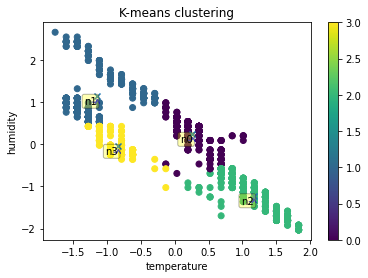

In [2]:
home_dir = '../datasets'
dataset = 'GNFUV-USV-Dataset'

# This variable contains the name of the columns and represents the variables we want to study
yvar='humidity'
xvar='temperature'
target_columns=[xvar,yvar]

# D represents the global dataset (all the points).
D = generate_dataset(home_dir,dataset)

from sklearn.preprocessing import StandardScaler

standaritzation = StandardScaler()
standaritzation.fit(D[target_columns])
scaled=standaritzation.transform(D[target_columns])
D_Scaled = D.copy()
D_Scaled[target_columns] = scaled

K=4
centroids,D_,kmeans = generate_data(D_Scaled,K,xvar,yvar)
plot_nodes(D_Scaled,centroids,xvar,yvar,kmeans)

index_model=0
models={}

gammas=[0.0001,0.001,0.01,0.1,1,10]
cs=[0.1,1,10,100]

def update_best(c,model,score,py,g,rmse,mse):
    d={}
    d['c']=c
    d['model']=model
    d['score']=score
    d['prediction']=py
    d['gamma']=g
    d['rmse']=rmse
    d['mse']=mse
    return d


best={}
for n in D_.keys():
    best[n]={}
    di=D_[n]['split']
    for g in gammas:
        for c in cs:
            model,score = train_model(di[Xtrain],di[Ytrain],di[Xtest],di[Ytest],C=c,gamma=g)
            mse,rmse,py=test_model(model,di[Xtest],di[Ytest])

            if best[n] == {}:
                best[n]= update_best(c,model,score,py,g,rmse,mse)
            elif rmse < best[n]['rmse']:
                best[n] = update_best(c,model,score,py,g,rmse,mse)
       

In [22]:
# d0 dataset from n0
# d1 dataset from n1
# n0 is adding points from n0

def add_outsiders(d0,d1,strategy,points,model=''):
    
    import copy
    new_d0 = copy.deepcopy(d0)
    
    d0x=new_d0['split'][Xtrain].values.tolist()
    d0y=new_d0['split'][Ytrain].values.tolist()
    
    if strategy=='kmeans':
        new_d1 = copy.deepcopy(d1)
        centroids,new_D,kmeans = generate_data(new_d1['full'],points,xvar,yvar,train=False)
        centroids_Df = pd.DataFrame(centroids, columns=target_columns)
        
        nd0x=[[x] for x in centroids_Df[xvar].values.tolist()]
        nd0y=centroids_Df[yvar].values.tolist() 
        
        xs=d0x + nd0x
        ys=d0y + nd0y
        
        new_d0['split'][Xtrain] =  pd.DataFrame(xs,columns=[xvar])
        new_d0['split'][Ytrain] = pd.Series(ys)
    
    if strategy=='percentile':
        
        from scipy.stats import sem
        
        p = ((100/points)/100) - 0.01
        noise = sem(d1['full'][xvar])
        _max = max(d1['full'][xvar])
        _min = min(d1['full'][xvar])
                               
        for i in range(points):
            v =  p + (p*i)
            vDf = pd.DataFrame(d1['full'].quantile(v)).T
            d0x.append([vDf.iloc[:,1].values[0]])
            d0y.append(vDf.iloc[:,0].values[0])
                
        new_d0['split'][Xtrain] =  pd.DataFrame(d0x,columns=[xvar])
        new_d0['split'][Ytrain] = pd.Series(d0y)
        
    if strategy=='random':
        for i in range(points):
            d0x.append(d1['split'][Xtrain].sample().values)
            d0y.append(d1['split'][Ytrain].sample().values)
            
        new_d0['split'][Xtrain] =  pd.DataFrame(d0x,columns=[xvar])
        new_d0['split'][Ytrain] = pd.Series(d0y)
        
    if strategy=='modelreuse':
        
            from scipy.stats import sem
            noise = sem(d1['full'][xvar])
            _max = max(d1['full'][xvar])
            _min = min(d1['full'][xvar])
            
            nd0x = np.random.uniform(low=_min, high=_max, size=points)
            nd0x = nd0x.reshape(-1, 1)
            dfake_x = pd.DataFrame(nd0x,columns=[xvar])
            nd0y = model.predict(dfake_x)
            nd0y = nd0y + noise**2
            
            xs = [element for lis in [d0x, nd0x] for element in lis]
            ys = [element for lis in [d0y, nd0y] for element in lis]

            new_d0['split'][Xtrain] =  pd.DataFrame(xs,columns=[xvar])
            new_d0['split'][Ytrain] = pd.Series(ys)

    return new_d0

#print(add_outsiders(D_['n0'],D_['n1'],'kmeans',15))
 

463


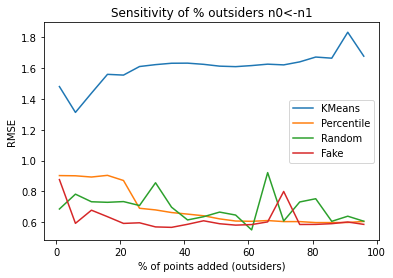

463


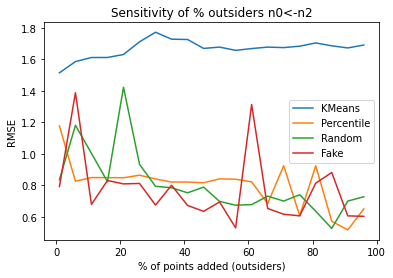

463


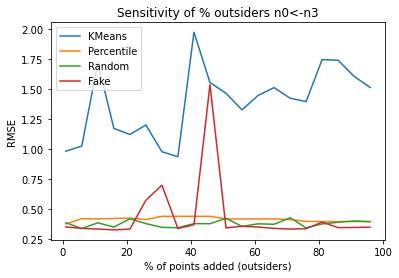

460


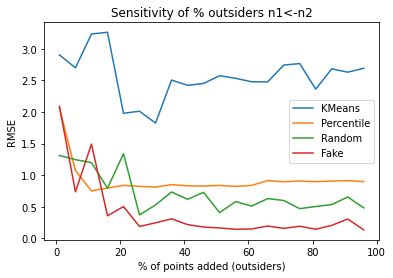

460


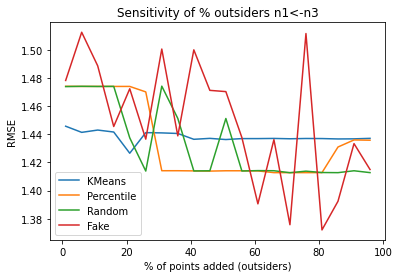

508


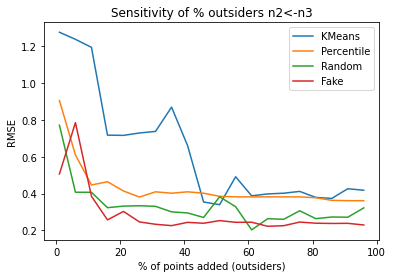

In [25]:
points_percent = [x for x in range(1,100,5)]

all_nodes = list(D_.keys())
import itertools
for nA, nB in itertools.combinations(all_nodes,2):

    dA = D_[nA]
    dB = D_[nB]

    total = len(dA['full'].index)
    print(total)

    rmse_kmenas=[]
    rmse_percentile=[]
    rmse_random=[]
    rmse_reuse=[]

    for p in points_percent:

        points = (p*100//total)+1

        new_dA=add_outsiders(dA,dB,'kmeans',points)
        model,score = train_model(new_dA['split'][Xtrain],new_dA['split'][Ytrain],new_dA['split'][Xtest],new_dA['split'][Ytest])
        mse,rmse,py=test_model(model,dB['split'][Xtest],dB['split'][Ytest])
        rmse_kmenas.append(rmse)

        new_dA=add_outsiders(dA,dB,'percentile',points)
        model,score = train_model(new_dA['split'][Xtrain],new_dA['split'][Ytrain],new_dA['split'][Xtest],new_dA['split'][Ytest])
        mse,rmse,py=test_model(model,dB['split'][Xtest],dB['split'][Ytest])
        rmse_percentile.append(rmse)

        new_dA=add_outsiders(dA,dB,'random',points)
        model,score = train_model(new_dA['split'][Xtrain],new_dA['split'][Ytrain],new_dA['split'][Xtest],new_dA['split'][Ytest])
        mse,rmse,py=test_model(model,dB['split'][Xtest],dB['split'][Ytest])
        rmse_random.append(rmse)

        m1,s1 = train_model(dB['split'][Xtrain],dB['split'][Ytrain],dB['split'][Xtest],dB['split'][Ytest])
        new_dA=add_outsiders(dA,dB,'modelreuse',points,model=m1)
        model,score = train_model(new_dA['split'][Xtrain],new_dA['split'][Ytrain],new_dA['split'][Xtest],new_dA['split'][Ytest])
        mse,rmse,py=test_model(model,dB['split'][Xtest],dB['split'][Ytest])
        rmse_reuse.append(rmse)


    import matplotlib.pyplot as plt   
    x=points_percent
    plt.plot(x, rmse_kmenas, label='KMeans')
    plt.plot(x, rmse_percentile, label='Percentile')
    plt.plot(x, rmse_random, label='Random')
    plt.plot(x, rmse_reuse, label='Fake')
    plt.title("Sensitivity of % outsiders {0}<-{1}".format(nA,nB))
    plt.ylabel("RMSE")
    plt.xlabel("% of points added (outsiders)")
    plt.legend()
    plt.show()